# Data Preprocessing and Library loading:

In [55]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("notebook")
sns.set_style(style="darkgrid")

In [56]:
jsonDir = "./jsonFiles"

fullTestSet = np.load("fullTestSet.npy")
errMSE = np.load("ERROR_MAE_3D_T1.npy")
with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [57]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [58]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
    metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [59]:
# Sort through subj to make sure all meta data present

keys = list(metaDict.keys())
keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [60]:
# Find out the keys present in every single case:

allMetaKeys = []
instTime = ["1","2","3","4","5","6","7"]
for k in keys:
    for i in instTime:
        allMetaKeys.extend(list(metaDict[k][i].keys()))

allMetaKeysSet = set(allMetaKeys)

keysOI = []
for k in allMetaKeysSet:
    if allMetaKeys.count(k) == (len(keys)*7):
        keysOI.append(k)

print("Meta values to use: \n\n", keysOI)


Meta values to use: 

 ['Study Time', 'Series Time', 'Percent Phase Field of View', 'Study Date', 'dB/dt', '[TimeAfterStart]', "Patient's Size", '[SliceMeasurementDuration]', 'Echo Train Length', '[SliceResolution]', 'Window Width', 'Percent Sampling', 'Bits Allocated', 'Repetition Time', 'Instance Creation Time', 'Slice Location', 'Pixel Bandwidth', '[CSA Image Header Version]', 'Columns', 'Magnetic Field Strength', 'Number of Averages', 'Rows', 'SAR', 'Instance Creation Date', '[CSA Series Header Version]', 'Imaging Frequency', 'Number of Phase Encoding Steps', "Patient's Weight", 'Series Date', 'Content Time', 'Echo Number(s)', '[CSA Image Header Version ??]', 'Instance Number', 'Bits Stored', 'Pixel Representation', 'Flip Angle', 'Inversion Time', 'Device Serial Number', 'Content Date', 'Acquisition Number', 'Largest Image Pixel Value', 'High Bit', 'Samples per Pixel', 'Acquisition Time', 'Slice Thickness', 'Window Center', 'Echo Time', '[RealDwellTime]', 'Series Number', "Patient'

In [61]:
# Create dataset:

subjLength = len(keys)
dataLength = len(keysOI)
bBoxesLength = 16
errLength = errFlat.shape[1]

ownDataset = np.zeros((subjLength,dataLength*len(instTime) + bBoxesLength + errLength))

k0 = list(tagDict.keys())[0]
tags = np.zeros((subjLength,len(tagDict[k0])))

for i,k in enumerate(keys):
    sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
    metaList = []
    for kOI in keysOI:
        for inst in instTime:
            metaList.append(metaDict[k][inst][kOI])
    try:
        metaList.extend(bBoxes[k]["Body"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    try:
        metaList.extend(bBoxes[k]["Liver"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    try:
        metaList.extend(bBoxes[k]["Lungs"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    try:
        metaList.extend(bBoxes[k]["Heart"])
    except KeyError as e:
        metaList.extend([0,0,0,0])

    charArr = np.char.find(fileList,k)
    charIdx = np.argwhere(charArr == 0)[0,0]
    
    assert(type(charIdx) == np.int64)
    errMeta = list(errFlat[charIdx,:])

    metaList.extend(errMeta)

    ownDataset[i,:] = np.array(metaList)
    if k in tagDict.keys():
        tags[i] = np.array(tagDict[k])

ownDataset = (ownDataset,tags)

print("Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

[31198/31199]Meta Data for Subj0: [193948.782 193948.782 193948.782 193948.782 193948.782 193948.782
 193948.782 194727.857 194727.857 194727.857] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [62]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength*len(instTime),bBoxesLength,errLength))

Header Meta Data: 364 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



# Train Multi Layer Perceptron:

## All Data:

In [63]:
# Hyperparameters:

testSize = 0.5
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,1,1)
early_stopping = False
verbose = False
activation = "relu"


In [64]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = MLPClassifier(activation=activation,verbose=verbose,early_stopping=early_stopping)

        y = y0[:,idx]
        X = x0[:,:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[11/12]

In [65]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count        1.0          1.0              1.0             1.0   
mean         0.5          0.5              0.5             0.5   
std          NaN          NaN              NaN             NaN   
min          0.5          0.5              0.5             0.5   
25%          0.5          0.5              0.5             0.5   
50%          0.5          0.5              0.5             0.5   
75%          0.5          0.5              0.5             0.5   
max          0.5          0.5              0.5             0.5   

       lookuptable-rip  m50pcfail  Other_Unlisted  pdff35  Rainbow  \
count              1.0        1.0             1.0     1.0      1.0   
mean               0.5        0.5             0.5     0.5      0.5   
std                NaN        NaN             NaN     NaN      NaN   
min                0.5        0.5             0.5     0.5      0.5   
25%                0.5        0.5             0.5     0

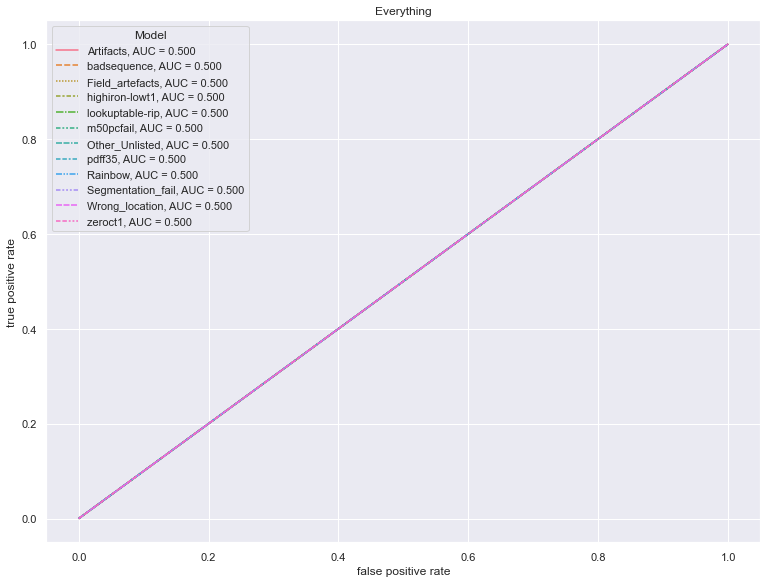

In [66]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [67]:
# Save Models
saveDir = "./models/MLP/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [68]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = MLPClassifier(activation=activation,verbose=verbose,early_stopping=True)

        y = y0[:,idx]
        X = x0[:,:-errLength]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[11/12]

In [69]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count        1.0          1.0              1.0             1.0   
mean         0.5          0.5              0.5             0.5   
std          NaN          NaN              NaN             NaN   
min          0.5          0.5              0.5             0.5   
25%          0.5          0.5              0.5             0.5   
50%          0.5          0.5              0.5             0.5   
75%          0.5          0.5              0.5             0.5   
max          0.5          0.5              0.5             0.5   

       lookuptable-rip  m50pcfail  Other_Unlisted  pdff35  Rainbow  \
count              1.0        1.0             1.0     1.0      1.0   
mean               0.5        0.5             0.5     0.5      0.5   
std                NaN        NaN             NaN     NaN      NaN   
min                0.5        0.5             0.5     0.5      0.5   
25%                0.5        0.5             0.5     0

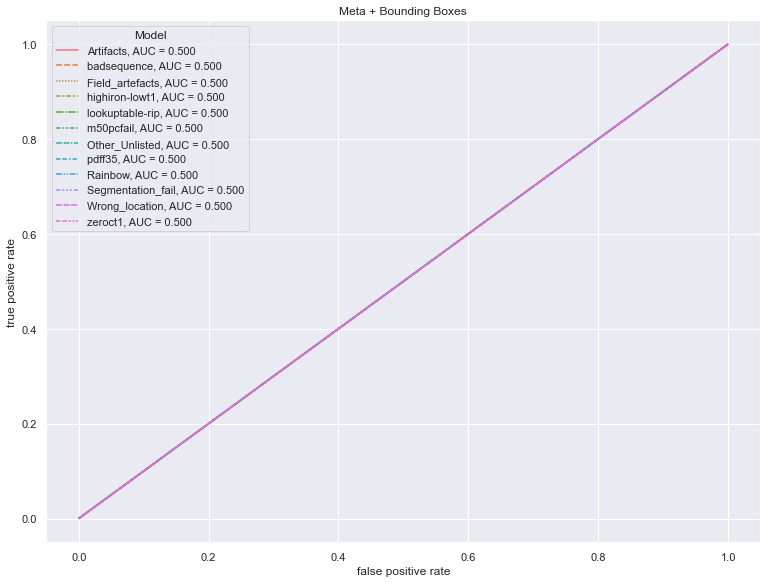

In [70]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [71]:
# Save Models
saveDir = "./models/MLP/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [72]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = MLPClassifier(activation=activation,verbose=verbose,early_stopping=early_stopping)

        y = y0[:,idx]
        X = x0[:,:-(bBoxesLength+errLength)]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[11/12]

In [73]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count        1.0          1.0              1.0             1.0   
mean         0.5          0.5              0.5             0.5   
std          NaN          NaN              NaN             NaN   
min          0.5          0.5              0.5             0.5   
25%          0.5          0.5              0.5             0.5   
50%          0.5          0.5              0.5             0.5   
75%          0.5          0.5              0.5             0.5   
max          0.5          0.5              0.5             0.5   

       lookuptable-rip  m50pcfail  Other_Unlisted  pdff35  Rainbow  \
count              1.0        1.0             1.0     1.0      1.0   
mean               0.5        0.5             0.5     0.5      0.5   
std                NaN        NaN             NaN     NaN      NaN   
min                0.5        0.5             0.5     0.5      0.5   
25%                0.5        0.5             0.5     0

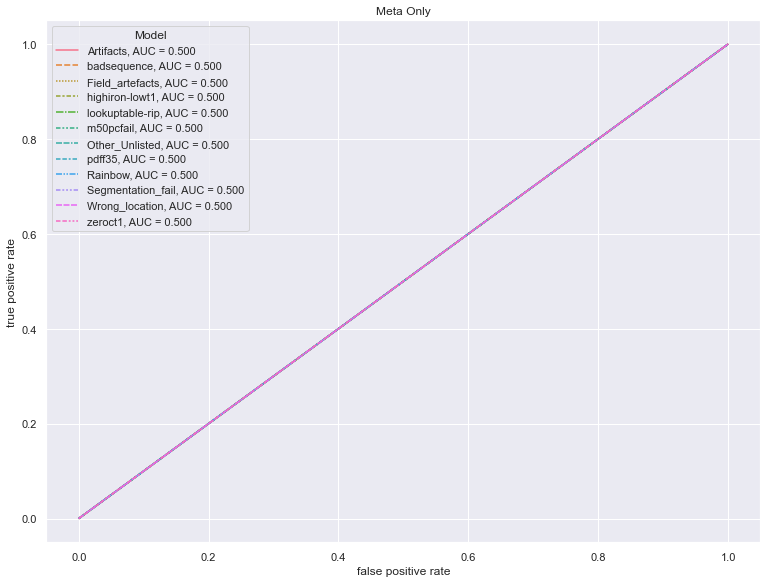

In [74]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [75]:
# Save Models
saveDir = "./models/MLP/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [76]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = MLPClassifier(activation=activation,verbose=verbose,early_stopping=early_stopping)

        y = y0[:,idx]
        X = x0[:,-errLength:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[11/12]

In [77]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count   1.000000     1.000000         1.000000        1.000000   
mean    0.654857     0.996001         0.852923        0.883939   
std          NaN          NaN              NaN             NaN   
min     0.654857     0.996001         0.852923        0.883939   
25%     0.654857     0.996001         0.852923        0.883939   
50%     0.654857     0.996001         0.852923        0.883939   
75%     0.654857     0.996001         0.852923        0.883939   
max     0.654857     0.996001         0.852923        0.883939   

       lookuptable-rip  m50pcfail  Other_Unlisted    pdff35   Rainbow  \
count         1.000000   1.000000        1.000000  1.000000  1.000000   
mean          0.810519   0.887572        0.876645  0.685102  0.922955   
std                NaN        NaN             NaN       NaN       NaN   
min           0.810519   0.887572        0.876645  0.685102  0.922955   
25%           0.810519   0.887572       

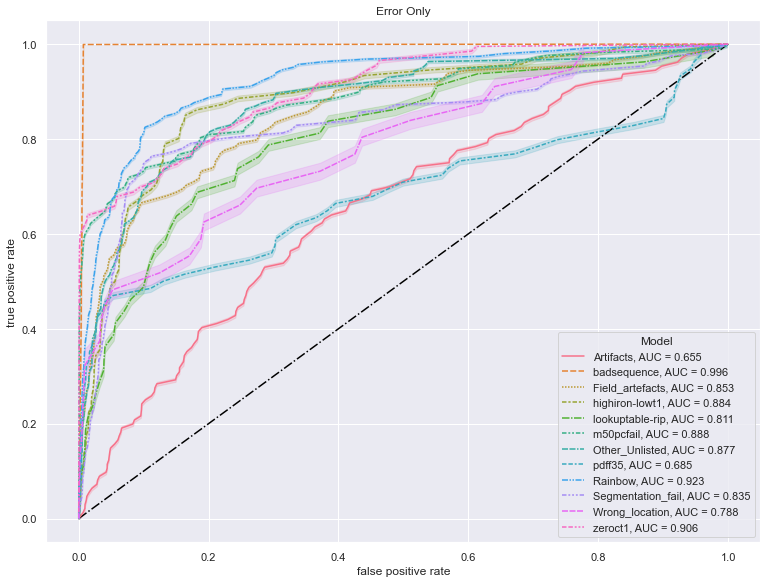

In [78]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [79]:
# Save Models
saveDir = "./models/MLP/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

                   All_Meta  Error_Only  Meta_BBoxes  Meta_Only
Artifacts               0.5    0.654857          0.5        0.5
badsequence             0.5    0.996001          0.5        0.5
Field_artefacts         0.5    0.852923          0.5        0.5
highiron-lowt1          0.5    0.883939          0.5        0.5
lookuptable-rip         0.5    0.810519          0.5        0.5
m50pcfail               0.5    0.887572          0.5        0.5
Other_Unlisted          0.5    0.876645          0.5        0.5
pdff35                  0.5    0.685102          0.5        0.5
Rainbow                 0.5    0.922955          0.5        0.5
Segmentation_fail       0.5    0.835359          0.5        0.5
Wrong_location          0.5    0.787705          0.5        0.5
zeroct1                 0.5    0.906364          0.5        0.5


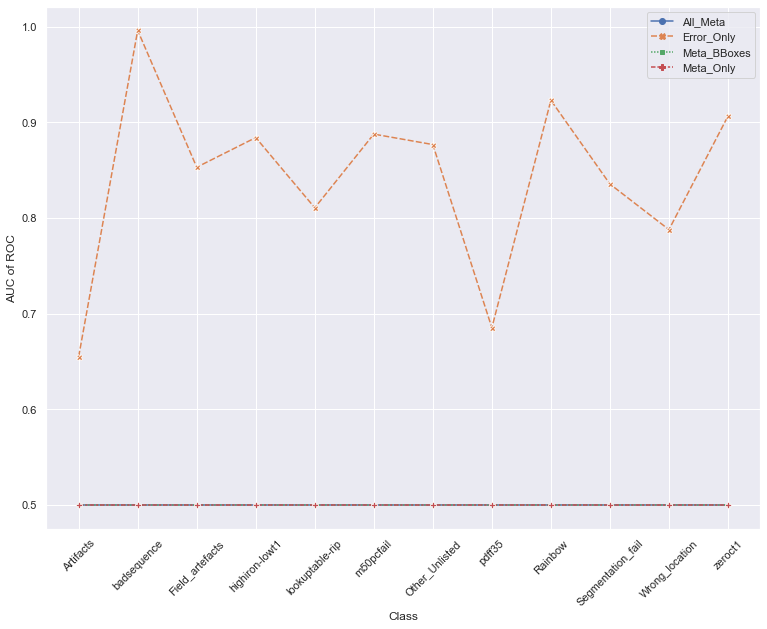

In [80]:
import seaborn as sns
import pandas as pd

loadDir = "./models/MLP/"

rfList = os.listdir(loadDir)

fullDict = {}
for fol in rfList:
    fullDict[fol] = {}
    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)
    for k1 in metrics.keys():
        avgAUC = []
        for k2 in metrics[k1].keys():
            avgAUC.append(metrics[k1][k2])
        fullDict[fol][k1] = np.mean(avgAUC)

df = pandas.DataFrame(fullDict)
print(df)

plt.figure()
sns.lineplot(data=df,markers=True)
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

In [ ]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = MLPClassifier(activation="tanh",verbose=True,early_stopping=True)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [ ]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


# Feature Importance:

In [ ]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()
